# Context
Term deposits are a key income source for banks, and telephonic marketing remains one of the most effective ways to sell them. However, these campaigns are resource-intensive, involving large call centers. To optimize efficiency, it's crucial to identify customers who are most likely to convert before reaching out. [This dataset](https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data) is related to direct telephonic marketing campaigns of a Portuguese bank, with the goal of predicting whether a customer will subscribe to a term deposit (yes/no). ***My own personal objectives are listed below.***

## Objectives
- Evaluate the effectiveness of a past campaign... Past Conversion Rate.
- Build a propensity model to estimate likelihood of future conversion.
- Identify optimal gain and estimated lift.

# Importing Important Libraries

In [1]:
# Data wrangling
import numpy as np
import pandas as pd

# Data vis
import seaborn as sns
import matplotlib.pyplot as plt

# Handling warnings
import warnings
warnings.filterwarnings('ignore')

## Data loading

In [2]:
train_df = pd.read_csv("/kaggle/input/banking-dataset-marketing-targets/train.csv", sep=";")
test_df = pd.read_csv("/kaggle/input/banking-dataset-marketing-targets/test.csv", sep=";")

In [3]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Some basic EDA

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
train_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


**Observation**   
Before even going further, It's worth discussing some extreme values, my assumptions, why and how I am handling some very extreme values.

- ***age:*** Upon further review, the dataset consists of people between 80 - 90+ who also get/don't get the term deposit, and I guess a 95 year could plausibly get a term deposits as some sort of inheritance so I will keep this observation. 
- ***balance:*** A quick gogle search reviewed the following `Yes, Portugal experienced a financial crisis between May 2008 and November 2010` which is the record yer of this dataset so a negatie balance that high is also quite plausible.
- ***duration:*** The dataset metadata describes duration as `last contact duration, in seconds (numeric)`. I don't know about you, but I would never be on a marketing call for *4918* seconds which equates to 81 minutes. I am dropping every observation this extreme.
- ***campaign:*** described as `number of contacts performed during this campaign and for this client (numeric, includes last contact)`. The mean contact is 2 with a reasonable standard deviation, and 75th percentile of 3. 63 contacts (calls) just seems impossible, I will be dropping observations this extreme.
- ***pdays:*** Defined as `number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)`. I will leave no contact as -1 and temporarily allow last campaign contact that extreme (more than 2 years ago). If I notice significant damage in propensity model, I will also exclude such extreme values.
- ***previous:*** Defined as `number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)`. When I sorted the dataset in descending order of previous, I noticed only 1 extreme outlier. I am excluding this from the rest of my work.

In [6]:
# Use this to observe top or bottom values of the data columns to
# further understand my reasons for the actions above.

column_name = 'previous'
numbers_to_return = 3
top_bottom = 2 # specify 1 for ascending order sort and 2 for descending order.. Defaults to Ascending. 

train_df.sort_values(by = column_name, ascending = True if top_bottom == 1 else False if top_bottom == 2 else 1).head(numbers_to_return)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no
38326,46,blue-collar,married,primary,no,1085,yes,yes,cellular,15,may,523,2,353,58,other,yes
44089,37,technician,married,secondary,no,432,yes,no,cellular,6,jul,386,3,776,55,failure,yes


In [7]:
# Handling the outliers from above

# Drop rows where duration exceeds 99.9th percentile
duration_99p9th = train_df['duration'].quantile(0.999)
print(f'Cut off value is {duration_99p9th}')
print(f'Number of *duration* outliers: {len(train_df[train_df["duration"] >= duration_99p9th])}\n')
train_df = train_df[train_df['duration'] <= duration_99p9th]

# Drop rows where campaign exceeds the 99.9th percentile
campaign_99p9th = train_df['campaign'].quantile(0.999)
print(f'Cut off value is {campaign_99p9th}')
print(f'Number of *campaign* outliers: {len(train_df[train_df["campaign"] >= campaign_99p9th])}\n')
train_df = train_df[train_df['campaign'] <= campaign_99p9th]

# Drop the single max row
previous_max = train_df['previous'].max()
print(f'Cut off value is {previous_max}')
print(f'Number of *previous* outliers: {len(train_df[train_df["previous"] == previous_max])}\n')
train_df = train_df[train_df['previous'] < previous_max]

Cut off value is 2091.740000000049
Number of *duration* outliers: 46

Cut off value is 32.0
Number of *campaign* outliers: 47

Cut off value is 275
Number of *previous* outliers: 1



In [8]:
train_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45126.000000,45126.000000,45126.000000,45126.000000,45126.000000,45126.000000,45126.000000
mean,40.936267,1362.618180,15.799295,255.818907,2.733280,40.259673,0.575145
std,10.620614,3046.351113,8.318581,244.796643,2.901453,100.193216,1.909467
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,449.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,2087.000000,32.000000,871.000000,58.000000


In [9]:
train_df.sort_values(by = 'duration', ascending = False).head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1416,43,management,divorced,tertiary,no,388,yes,no,unknown,8,may,2087,2,-1,0,unknown,yes
16454,32,blue-collar,single,secondary,no,799,no,yes,cellular,23,jul,2078,6,-1,0,unknown,yes
42534,68,retired,married,secondary,no,1443,no,no,telephone,21,dec,2062,2,257,1,success,yes


**Observation**   
Everything makes much more sense now... The `max duration` is still kind of high at 2087 seconds ~= 35 minutes but I will accept that under the guise that the person on the receiving end was just curious about all the details and wanted to know exactly what they were getting into.

If you notice, the person who had the longest call holds a ***manager*** level job so it makes sense that they are quizing the marketer and want to know as much information before making a strategic financial decision. Their balance is quite low which is suspecious but the person may have other bank accounts while this one is strictly for very small expenses, assuming the amount column isnt expressed in thousands. Same with the blue-collar worked who follows after. The person doesn't seem to have much money so would be wise to know all details before taking the financial decision.

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45126 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45126 non-null  int64 
 1   job        45126 non-null  object
 2   marital    45126 non-null  object
 3   education  45126 non-null  object
 4   default    45126 non-null  object
 5   balance    45126 non-null  int64 
 6   housing    45126 non-null  object
 7   loan       45126 non-null  object
 8   contact    45126 non-null  object
 9   day        45126 non-null  int64 
 10  month      45126 non-null  object
 11  duration   45126 non-null  int64 
 12  campaign   45126 non-null  int64 
 13  pdays      45126 non-null  int64 
 14  previous   45126 non-null  int64 
 15  poutcome   45126 non-null  object
 16  y          45126 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


## Evaluating effectiveness of past campaign

In [11]:
past_conversion = train_df['y'].value_counts(normalize=True).values[1]
print(f'The conversion rate for the past campaign was {past_conversion * 100:.3}%')

The conversion rate for the past campaign was 11.7%


**Note**   
10% - 12% is a reasonable conversion rate for random targeting... Let's investigate what this looks like across the different covariates.

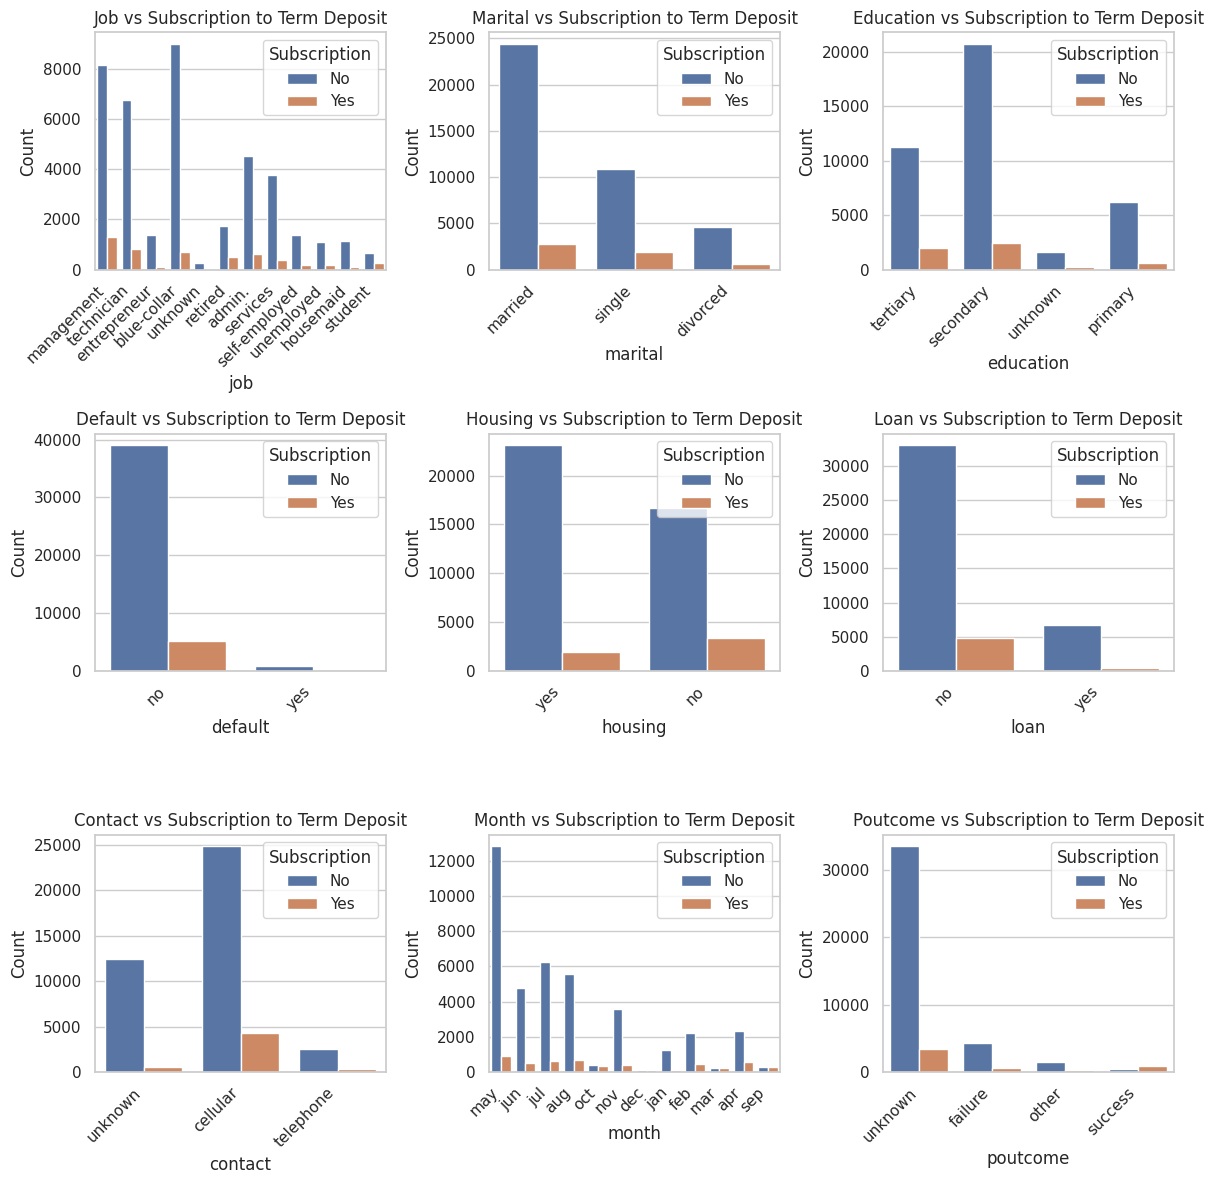

In [12]:
categorical_columns = train_df.select_dtypes(include = ['object']).columns.drop('y')

sns.set(style = "whitegrid")
plt.figure(figsize = (12, 12))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x = col, hue = 'y', data = train_df)
    plt.title(f'{col.title()} vs Subscription to Term Deposit')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation = 45, ha = 'right')
    plt.legend(title = 'Subscription', labels = ['No', 'Yes'])

plt.tight_layout()
plt.show()

**Observations**   

For the categorical columns above:
- ***Job***: Those assuming managerial positions converted the most as a result of the past campaign, while those who are entrepreneurs or housemaids converted the least.

- ***Marital***: Single individuals had the highest term deposit subscription rate, while divorced individuals had the lowest.

- ***Education***: Individuals with tertiary education had the highest subscription rate, while those with primary education had the lowest.

- ***Default***: Clients with no credit default had significantly higher subscriptions; those with defaults rarely subscribed.

- ***Housing***: Clients without housing loans subscribed more compared to those with housing loans.

- ***Loan***: Clients without personal loans had the highest subscription rate, whereas those with personal loans subscribed much less.

- ***Contact***: Clients contacted via cellular phones subscribed the most, while those contacted via telephone had the lowest turnout.

- ***Month***: The month of May saw the highest number of subscriptions, while March and December had the lowest.

- ***Poutcome***: Clients with a successful previous campaign outcome had the highest subscription rate; those with an outcome marked "failure" or "other" had lower turnout, and those with "unknown" had the least.

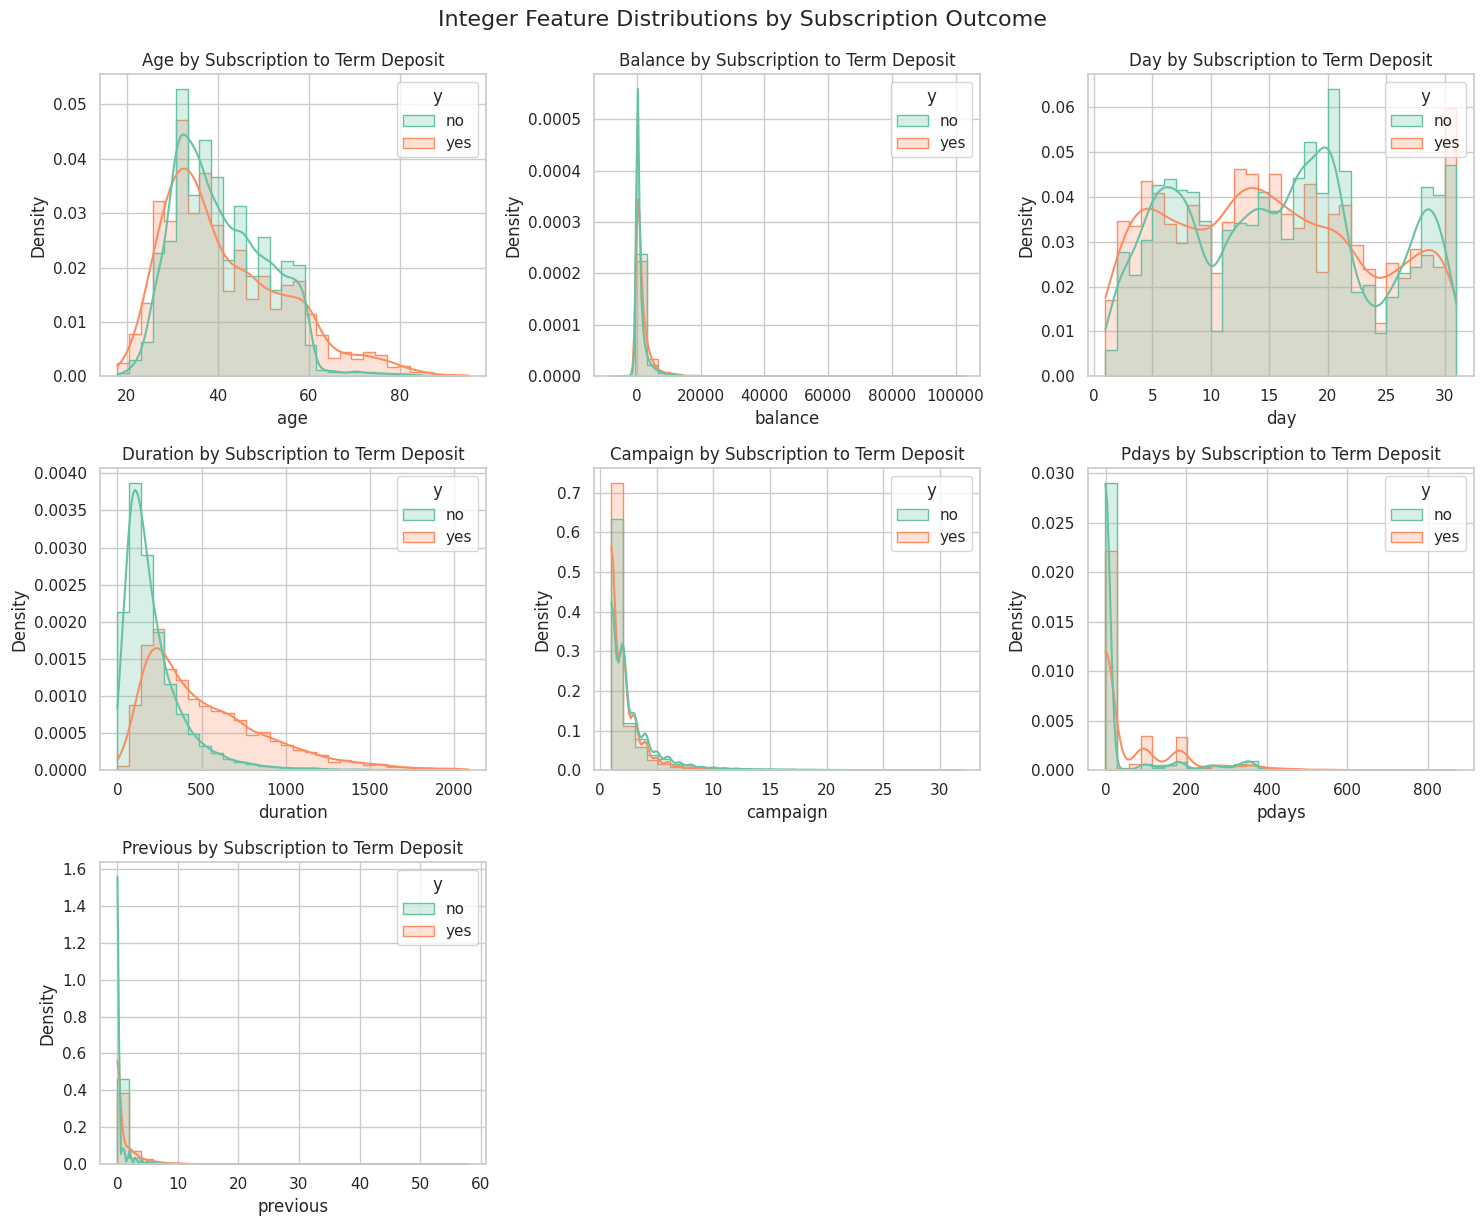

In [13]:
int_columns = train_df.select_dtypes(include=['int64', 'int32']).columns

n_cols = 3
n_rows = int(np.ceil(len(int_columns) / n_cols))

plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Adjust figure size

# Loop through columns
for i, col in enumerate(int_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=train_df, x=col, hue='y', bins=30, kde=True,
                 palette='Set2', element='step', stat='density', common_norm=False)
    plt.title(f'{col.title()} by Subscription to Term Deposit')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()

plt.suptitle('Integer Feature Distributions by Subscription Outcome', fontsize=16, y=1.02)
plt.show()

**Observations**   

For the numerical columns above:
- ***Age***: Subscribers were generally older than non-subscribers, with a noticeable density in the 30–60 age range for successful subscriptions.

- ***Balance***: Clients with higher account balances showed a higher likelihood of subscribing; non-subscribers were concentrated around lower balances.

- ***Day***: There is no strong trend across days of the month; both subscribers and non-subscribers are relatively evenly distributed.

- ***Duration***: Call duration is highly influential, longer call durations were strongly associated with successful subscriptions.

- ***Campaign***: Fewer campaign contacts (1–3 times) were more effective; the probability of subscription decreased as the number of contacts increased.... That is sensible because if they didn't subscribe during 3 contacts then it's probably because they are really not interested.

- ***Pdays***: A high subscription rate is observed when clients had been contacted recently (low pdays values); the likelihood of success drops significantly for longer delays or never-contacted clients.

- ***Previous***: Those who had been contacted fewer times in past campaigns (especially 1–2 times) had higher success rates. The probability drops with increasing previous contacts.
